In this version, use Anthony's set up for P0YP0 P1YP1, and implement concurrent VQE

In [85]:
%run SetUp.ipynb

from scipy.optimize import minimize

In [86]:
import cmath

In [87]:
nQ = 6

## Define VQE form

In [88]:
# VQE
# "state" is the state PYP acts on. Implementing this way to not have to generate an entire matrix and save running time. 
# odd layer theta0*POYPO theta1*P1YP1 then even layer

def PYP(angle1,angle2, nq,state):
    n_sets = int(nq/2)
    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0),state) #-1j * 
        state = sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1),state)
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0),state)
        state =  sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1),state)
    return state


In [89]:

# Generate Fake Vacuum
# version that generates [[1,0,...]] and has dimension issues:  
#  fake_vac = ft.reduce(sp.sparse.kron, [[1,0]]* nq)

#fake_vac = sp.sparse.csr_array(np.ndarray.flatten(ft.reduce(sp.sparse.kron, [[1,0]]* nq).toarray()))

def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray(),dtype = np.cfloat).transpose()

## Set up function to minimize and initial points

In [90]:
num_params = 2
fake_vac_nQ = fake_vac(nQ) # predefine to save runtime

In [91]:

# activate 1 site. 

def activate1(init,loc,nq): # init is a function of nq, init(nq) is a state, loc is which link is activated
    #P0XP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),x,sp.sparse.identity(2**(nq-loc-1))]) 
    return act_mat @ init(nq)

#### Concurrent VQE

In [92]:
import h5py

In [93]:
with h5py.File('/Users/zhiyaoli/IQuS Dropbox/Zhiyao Li/String \
Breaking/Data/eigenstates.h5', 'r') as f:
    data = f['Dataset1'][:]

In [94]:
data.shape

(7, 64)

In [95]:
meson_p_full = []

for i in range(len(data)-1):
    real_part = data[i]["Re"]
    imag_part = data[i]["Im"]
    complex_data = real_part + 1j * imag_part
    meson_p_full.append(complex_data)

real_part = data[-1]["Re"]
imag_part = data[-1]["Im"]
vac_full = real_part + 1j * imag_part    

In [96]:
p_list = [(2*math.pi/LL)*(index+1) -math.pi for index in range(nQ)]

In [97]:
p_list

[-2.0943951023931957,
 -1.0471975511965979,
 0.0,
 1.0471975511965974,
 2.094395102393195,
 3.141592653589793]

In [136]:
### Define alternate cost function to maximize for Concurrent VQE

LL = nQ # 2L = nQ
# vac_full and meson_p_full are the eigenstates of the full Hamiltonian. Need to be defined. 

def cost_func(angles):
    angle1, angle2 = angles[0], angles[1]    
    
    vac_state = PYP(angle1,angle2,nQ,fake_vac_nQ) 
    
    meson_overlap = 0
    for index in range(LL): # p goes from -Pi*(l-1)/L to Pi
        if index == 2: # skipping the p = 0 case
            continue
        
        p = p_list[index]
        
        # Sum over x to get |p>
        mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray(), dtype = np.cfloat).transpose()
        for xx in range(nQ):
            meson_state = activate1(fake_vac,xx,nQ)
            mesons += cmath.exp(1j*p*xx) * meson_state
            
        meson_p = PYP(angle1,angle2,nQ,mesons/math.sqrt(LL)) 
        meson_overlap += overlap(meson_p_full[index],meson_p)**2
    
    return 2*(LL+1)-(overlap(vac_full,vac_state)**2 + meson_overlap)

In [137]:
initial_point = np.random.rand(num_params)

In [138]:
cost_func(initial_point)

11.716326540489224

In [139]:
cost_func([0.178,0.078])

9.900184073145633

In [140]:
cost_func([-0.17923051, -0.10247442])

8.004357286380355

In [141]:
initial_point

array([0.40240564, 0.2584718 ])

## Run VQE

#### nelder-mead

In [104]:
res = minimize(cost_func, initial_point, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: 8.004331
         Iterations: 79
         Function evaluations: 159


In [105]:
print(res.x)

[-0.18010458  6.17716577]


#### powell

In [142]:
res2 = minimize(cost_func, initial_point, method='powell',
               options={'disp': True})

Optimization terminated successfully.
         Current function value: 8.004356
         Iterations: 2
         Function evaluations: 46


In [143]:
print(res2.x)

[-0.17929116 -0.1060088 ]


#### BFGS

In [144]:
res3 = minimize(cost_func,initial_point, method='BFGS', tol = 1e-8,
               options={'disp': True})

# tol = 1e-8,
# xatol = 1e-8,

Optimization terminated successfully.
         Current function value: 8.004356
         Iterations: 10
         Function evaluations: 39
         Gradient evaluations: 13


In [145]:
print(res3.x)

[-0.17929115 -0.10599291]


## Test

#### Concurrent VQE check

In [156]:
scipy_angles = [-0.17929116, -0.1060088]
scipy_results = np.reshape(PYP(-0.17929116, -0.1060088,nQ,fake_vac_nQ).toarray(),-1)

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


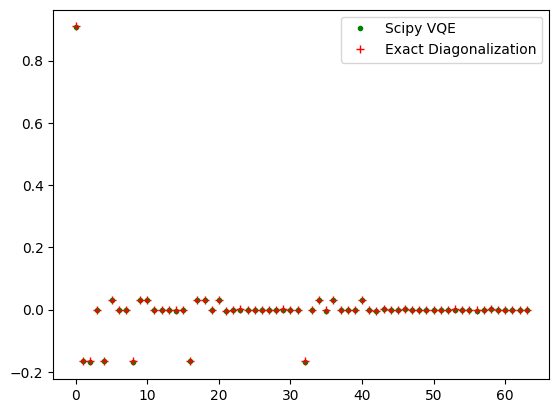

In [157]:
plt.plot(list(range(2**nQ)), scipy_results,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ)),-vac_full,'r+',label = 'Exact Diagonalization')
plt.legend()

In [158]:
for index in range(nQ):
    mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray()).transpose()
    p = p_list[index]
    for xx in range(nQ):
        meson_state = activate1(fake_vac,xx,nQ)
        mesons += cmath.exp(1j*p*xx) * meson_state
    meson_p = PYP(-0.17929116, -0.1060088,nQ,mesons/math.sqrt(LL)) 
    print(f"index: {index} , Overlap {overlap(meson_p_full[index],meson_p)**2}, p: {p}")

index: 0 , Overlap 0.99955697313414, p: -2.0943951023931957
index: 1 , Overlap 0.9992095463295037, p: -1.0471975511965979
index: 2 , Overlap 1.6935473695863963e-05, p: 0.0
index: 3 , Overlap 0.9992095463295039, p: 1.0471975511965974
index: 4 , Overlap 0.9995569731341403, p: 2.094395102393195
index: 5 , Overlap 0.9981941413180668, p: 3.141592653589793


In [147]:
def get_meson_p_prob(index):
    p = p_list[index]
    mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray()).transpose()
    for xx in range(nQ):
        meson_state = activate1(fake_vac,xx,nQ)
        mesons += cmath.exp(1j*p*xx) * meson_state
    state = PYP(-0.17988941, -0.10526204,nQ,mesons/math.sqrt(LL))
    # state = PYP(-0.17988941, -0.10526204,nQ,fake_vac_nQ)
    return np.abs(state)**2

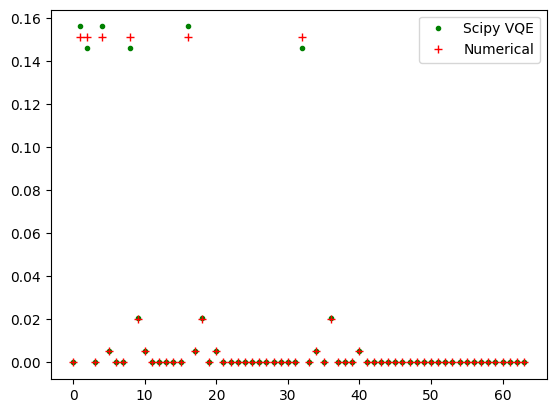

In [155]:
which_p = 0
plt.plot(list(range(2**nQ)), np.reshape(get_meson_p_prob(which_p).toarray(),-1),'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ)), np.abs(meson_p_full[which_p])**2,'r+',label = 'Numerical')
plt.legend()

In [119]:
np.abs(np.array(meson_p_full[2]).conj().T @ np.array(meson_p_full[-1]))

2.1899133756386746e-09